<a href="https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_standard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to single-cell RNA-seq II: getting started with analysis

This notebook demonstrates pre-processing and basic analysis of the [mouse retinal cells SRR8599150](https://www.ncbi.nlm.nih.gov/sra/?term=SRR8599150) dataset from [Koren et al., 2019](https://doi.org/10.1016/j.immuni.2019.02.007). Following pre-processing using kallisto and bustools and basic QC, the notebook demonstrates some initial analysis. The approximate running time of the notebook is 12 minutes.

The notebook was written by Kyung Hoi (Joseph) Min, A. Sina Booeshaghi and Lior Pachter.

If you use the methods in this notebook for your analysis please cite the following publications which describe the tools used in the notebook:

* Melsted, P., Booeshaghi, A.S. et al. Modular and efficient pre-processing of single-cell RNA-seq. bioRxiv (2019). doi:10.1101/673285
* Wolf, F. A., Angere, P. and Theis, F.J. SCANPY: large-scale single-cell gene expression data analysis. Genome Biology (2018). doi:10.1186/s13059-017-1382-0


## Setup

In [0]:
# This is  used to time the running of the notebook
import time
start_time = time.time()

### Install python packages

In [2]:
# These packages are pre-installed on Google Colab, but are included here to simplify running this notebook locally
!pip install matplotlib
!pip install scikit-learn
!pip install numpy
!pip install scipy

In [3]:
%%time
# `kb` is a wrapper for the kallisto and bustools program, and the kb-python package contains the kallisto and bustools executables.
!pip install kb-python==0.24.1

     |████████████████████████████████| 35.4MB 90kB/s 
     |████████████████████████████████| 51kB 9.7MB/s 
     |████████████████████████████████| 102kB 14.1MB/s 
     |████████████████████████████████| 51kB 9.3MB/s 
  Created wheel for loompy: filename=loompy-3.0.6-cp36-none-any.whl size=47896 sha256=c37b22a3be2d7f701d0f877292fb2cf07a4e3986a92ad2005230b26469afc6ba
  Stored in directory: /root/.cache/pip/wheels/f9/a4/90/5a98ad83419732b0fba533b81a2a52ba3dbe230a936ca4cdc9
  Created wheel for numpy-groupies: filename=numpy_groupies-0+unknown-cp36-none-any.whl size=28044 sha256=2e083ceefbd35c8cbee1a18eec82279305b4c90386621d06df98db63cf56e3b8
  Stored in directory: /root/.cache/pip/wheels/30/ac/83/64d5f9293aeaec63f9539142fc629a41af064cae1b3d8d94aa
Successfully built loompy numpy-groupies
CPU times: user 243 ms, sys: 54 ms, total: 297 ms
Wall time: 9.06 s


In [4]:
%%time
# Install scanpy and other packages needed for single-cell RNA-seq analysis
!pip install scanpy python-igraph louvain MulticoreTSNE

     |████████████████████████████████| 6.5MB 4.3MB/s 
     |████████████████████████████████| 378kB 66.2MB/s 
     |████████████████████████████████| 92kB 13.2MB/s 
     |████████████████████████████████| 2.9MB 36.6MB/s 
     |████████████████████████████████| 13.0MB 47.7MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
  Created wheel for python-igraph: filename=python_igraph-0.7.1.post6-cp36-cp36m-linux_x86_64.whl size=2221617 sha256=2b117408d9f10974dc1454e9780eb13cbfd65d66af499034f0ebb8576df07454
  Stored in directory: /root/.cache/pip/wheels/41/d6/02/34eebae97e25f5b87d60f4c0687e00523e3f244fa41bc3f4a7
  Created wheel for louvain: filename=louvain-0.6.1-cp36-cp36m-linux_x86_64.whl size=1024677 sha256=bf356dd4a1d626487da5fe8dc1f6a087c934a400a9b1e1d90676d69b0b35e0a9
  Stored in directory: /root/.cache/pip/wheels/f2/c3/d4/f7abaf064186d6214ef952bbb72fd6c5136d4b17dbeaeff481
  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp36-cp36m-linux_x86_64.whl size=68507 sha2

CPU times: user 1.28 s, sys: 147 ms, total: 1.43 s
Wall time: 5min 11s


In [5]:
%%time 
# Import packages
import anndata
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from scipy import sparse, io

matplotlib.rcParams.update({'font.size': 12})
%config InlineBackend.figure_format = 'retina'

CPU times: user 834 ms, sys: 122 ms, total: 956 ms
Wall time: 2.68 s


### Downloading the data

__Note:__ We use the `-O` option for `wget` to rename the files so they can be easily identified. The notebook requires reads in fastq format; the files can be processed in gzip compressed format.

In this example the reads are downloaded from a Box drive; see the [data download](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/data_download.ipynb) notebook for information on where to find publicly available single-cell RNA-seq data.

In [6]:
%%time
!wget https://caltech.box.com/shared/static/9u2qk1uqu6py03phooe1ti0kjd9v87pu.txt -O checksums.txt
!wget https://caltech.box.com/shared/static/w9ww8et5o029s2e3usjzpbq8lpot29rh.gz -O SRR8599150_S1_L001_R1_001.fastq.gz
!wget https://caltech.box.com/shared/static/ql00zyvqnpy7bf8ogdoe9zfy907guzy9.gz -O SRR8599150_S1_L001_R2_001.fastq.gz

--2020-02-02 08:16:25--  https://caltech.box.com/shared/static/9u2qk1uqu6py03phooe1ti0kjd9v87pu.txt
Resolving caltech.box.com (caltech.box.com)... 107.152.24.197, 107.152.25.197
Connecting to caltech.box.com (caltech.box.com)|107.152.24.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9u2qk1uqu6py03phooe1ti0kjd9v87pu.txt [following]
--2020-02-02 08:16:25--  https://caltech.box.com/public/static/9u2qk1uqu6py03phooe1ti0kjd9v87pu.txt
Reusing existing connection to caltech.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://caltech.app.box.com/public/static/9u2qk1uqu6py03phooe1ti0kjd9v87pu.txt [following]
--2020-02-02 08:16:25--  https://caltech.app.box.com/public/static/9u2qk1uqu6py03phooe1ti0kjd9v87pu.txt
Resolving caltech.app.box.com (caltech.app.box.com)... 107.152.25.199, 107.152.24.199
Connecting to caltech.app.box.com (caltech.app.box.com)|107.152.25.199|:443... connected.
HTTP requ



```
# This is formatted as code
```

Next, we verify the integrity of the files that were downloaded to confirm that they were not corrupted during the download.

In [7]:
!md5sum -c checksums.txt --ignore-missing

SRR8599150_S1_L001_R1_001.fastq.gz: OK
SRR8599150_S1_L001_R2_001.fastq.gz: OK


### Downloading an index

__Note:__ See [this notebook](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_transcriptome_index.ipynb) for a tutorial on how to build custom transcriptome indices or indices for RNA velocity.

In [8]:
%%time
# This downloads a pre-built index for kallisto to use when pseudoaligning the reads
!kb ref -d mouse -i index.idx -g t2g.txt

[2020-02-02 08:17:06,124]    INFO Downloading files for mouse from https://caltech.box.com/shared/static/vcaz6cujop0xuapdmz0pplp3aoqc41si.gz to tmp/vcaz6cujop0xuapdmz0pplp3aoqc41si.gz
[2020-02-02 08:18:32,186]    INFO Extracting files from tmp/vcaz6cujop0xuapdmz0pplp3aoqc41si.gz
CPU times: user 461 ms, sys: 62.5 ms, total: 524 ms
Wall time: 2min 9s


## Pseudoalignment and counting

### Run kallisto and bustools

The following command will generate an RNA count matrix of cells (rows) by genes (columns) in H5AD format, which is a binary format used to store [Anndata](https://anndata.readthedocs.io/en/stable/) objects. Notice that this requires providing the index and transcript-to-gene mapping downloaded in the previous step to the `-i` and `-g` arguments respectively. Also, since the reads were generated with the 10x Genomics Chromium Single Cell v2 Chemistry, the `-x 10xv2` argument is used. To view other supported technologies, run `kb --list`.

__Note:__ To output a [Loom](https://linnarssonlab.org/loompy/format/index.html) file instead, replace the `--h5ad` flag with `--loom`. To obtain the raw matrix output by `kb` instead of the H5AD or Loom converted files, omit these flags.

In [9]:
%%time
# This step runs `kb` to pseudoalign the reads, and then generate the cells x gene matrix in h5ad format.
!kb count -i index.idx -g t2g.txt -x 10xv2 --h5ad -t 2 \
SRR8599150_S1_L001_R1_001.fastq.gz SRR8599150_S1_L001_R2_001.fastq.gz

[2020-02-02 08:19:15,664]    INFO Generating BUS file from
[2020-02-02 08:19:15,664]    INFO         SRR8599150_S1_L001_R1_001.fastq.gz
[2020-02-02 08:19:15,664]    INFO         SRR8599150_S1_L001_R2_001.fastq.gz
[2020-02-02 08:21:41,760]    INFO Sorting BUS file ./output.bus to tmp/output.s.bus
[2020-02-02 08:21:45,085]    INFO Whitelist not provided
[2020-02-02 08:21:45,086]    INFO Copying pre-packaged 10XV2 whitelist to .
[2020-02-02 08:21:45,189]    INFO Inspecting BUS file tmp/output.s.bus
[2020-02-02 08:21:46,735]    INFO Correcting BUS records in tmp/output.s.bus to tmp/output.s.c.bus with whitelist ./10xv2_whitelist.txt
[2020-02-02 08:22:02,217]    INFO Sorting BUS file tmp/output.s.c.bus to ./output.unfiltered.bus
[2020-02-02 08:22:05,222]    INFO Generating count matrix ./counts_unfiltered/cells_x_genes from BUS file ./output.unfiltered.bus
[2020-02-02 08:22:07,390]    INFO Converting matrix ./counts_unfiltered/cells_x_genes.mtx to h5ad ./counts_unfiltered/adata.h5ad
CPU tim

## Basic QC

First, the *cells x genes* matrix is imported into an H5AD-formatted Anndata matrix

In [10]:
%%time
# import data
adata = anndata.read('counts_unfiltered/adata.h5ad')
adata

CPU times: user 77.6 ms, sys: 23.8 ms, total: 101 ms
Wall time: 112 ms


### Test for library saturation

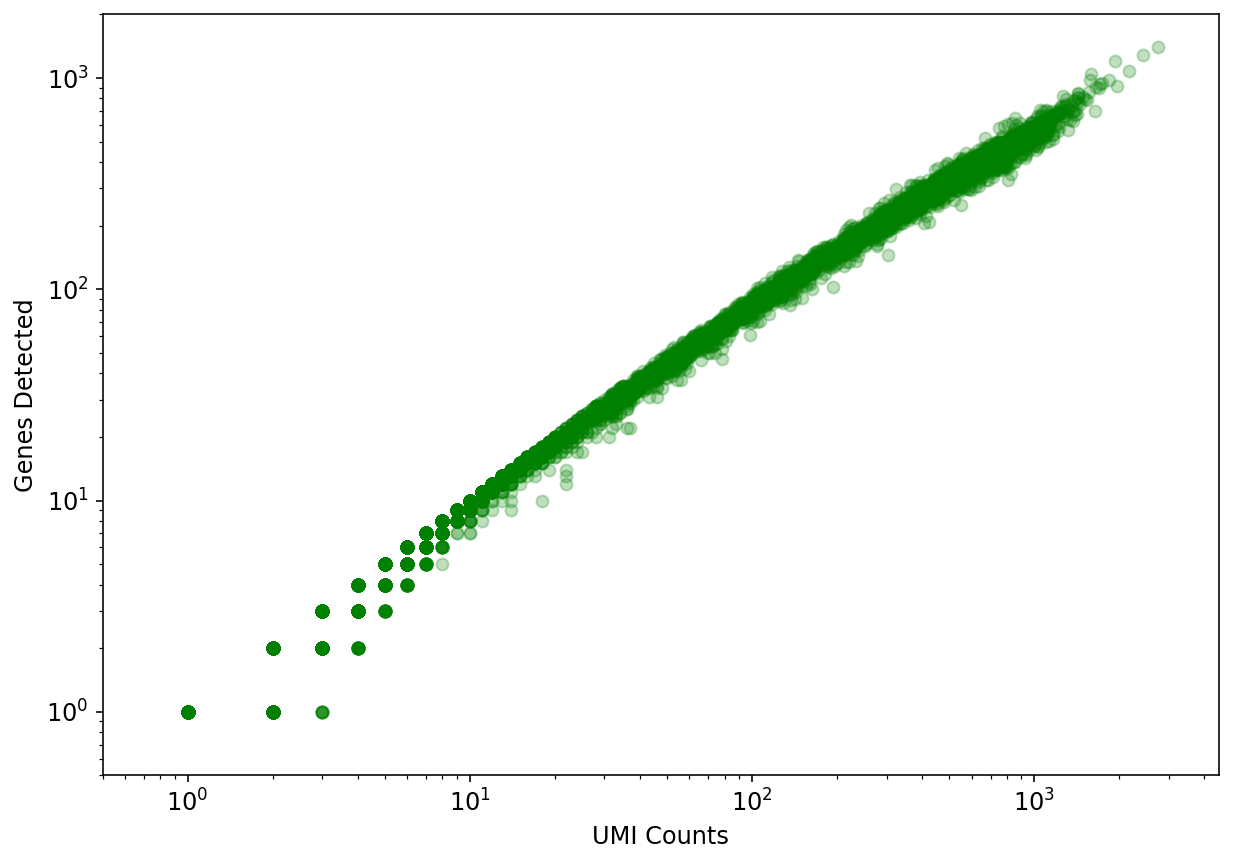

In [11]:
# Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(np.asarray(adata.X.sum(axis=1))[:,0], np.asarray(np.sum(adata.X>0, axis=1))[:,0], color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log', nonposy='clip')

ax.set_xlim((0.5, 4500))
ax.set_ylim((0.5,2000))


plt.show()

### Examine the knee plot

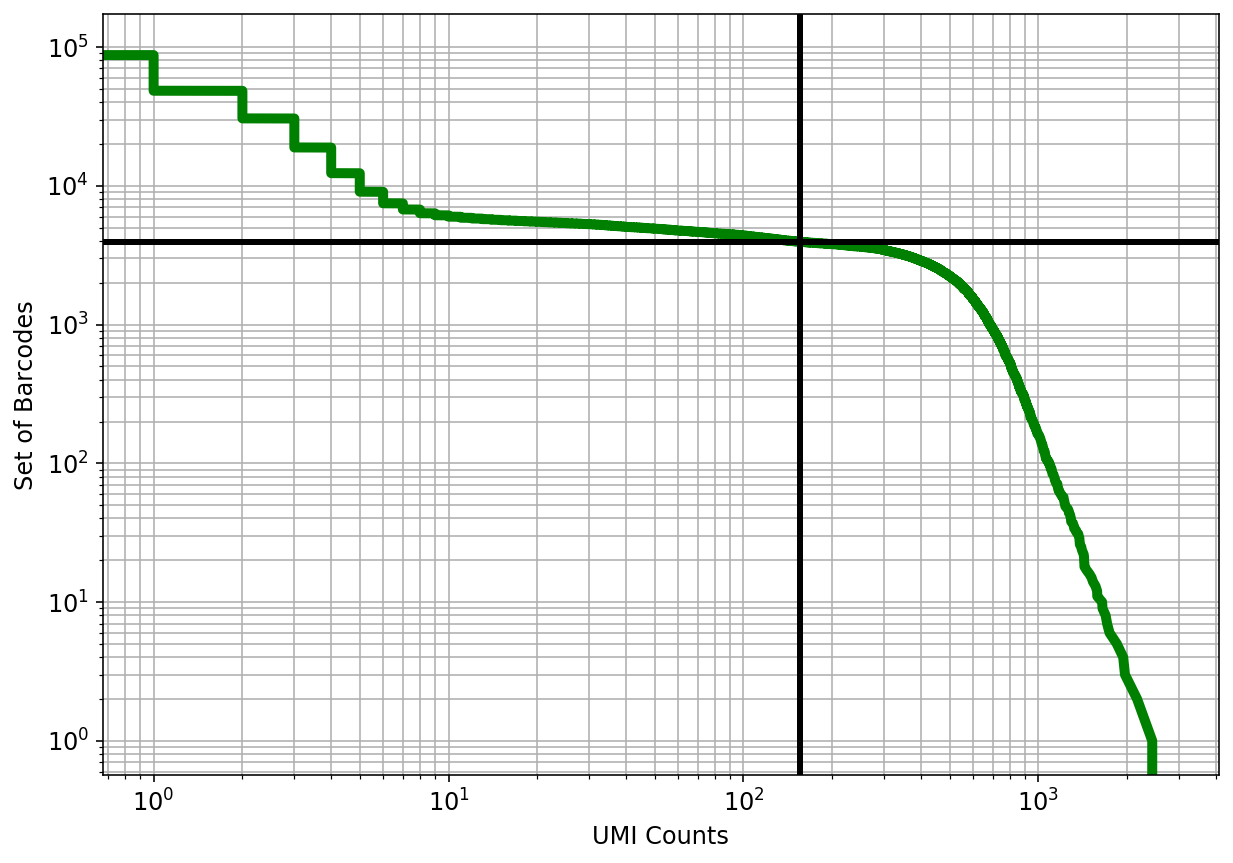

In [12]:
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

fig, ax = plt.subplots(figsize=(10, 7))

expected_num_cells=3949

ax.loglog(knee, range(len(knee)), linewidth=5, color="g")
ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

### Filter the cells

In [0]:
# Filter the cells according to the threshold determined from the knee plot
sc.pp.filter_cells(adata, min_genes=0)
sc.pp.filter_cells(adata, min_counts=knee[expected_num_cells])
sc.pp.filter_genes(adata, min_cells=0)

### Visualizing count distributions

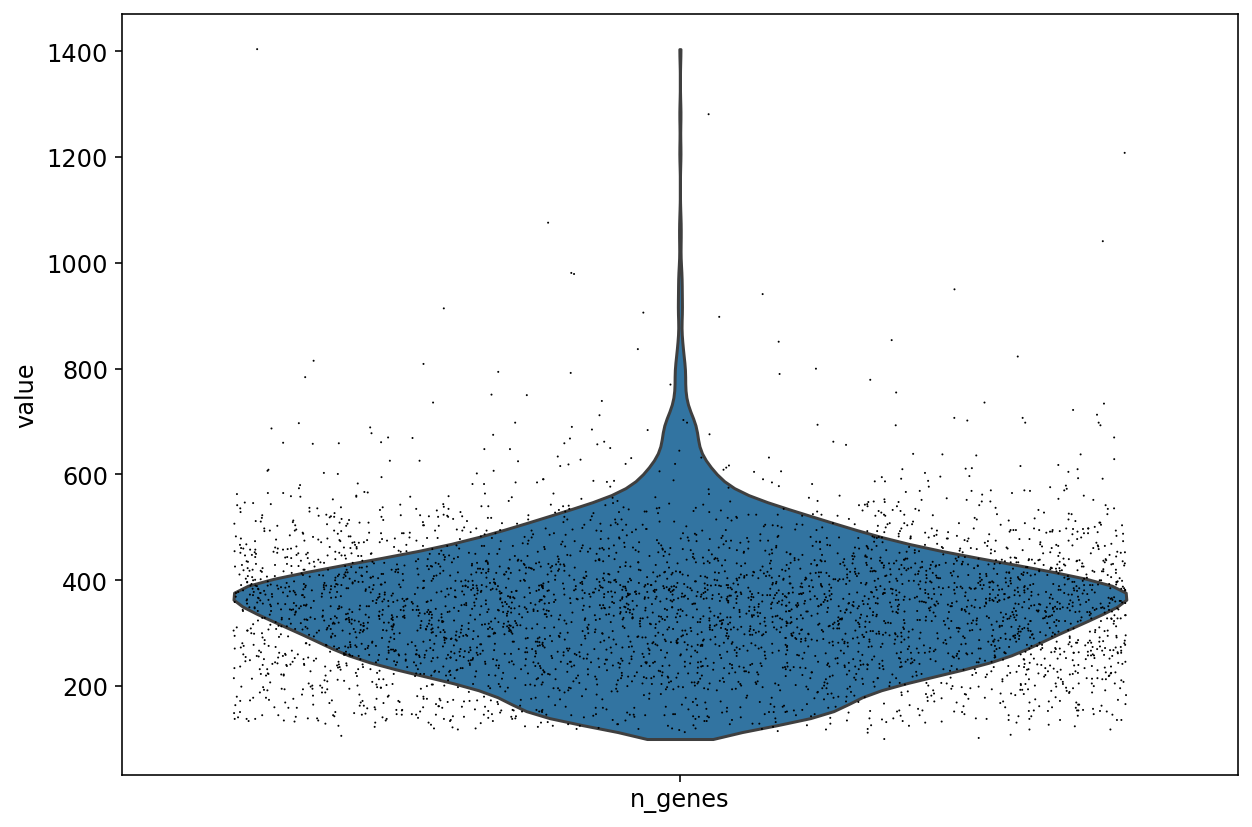

In [14]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.violin(adata, 'n_genes', jitter=0.4, ax=ax)

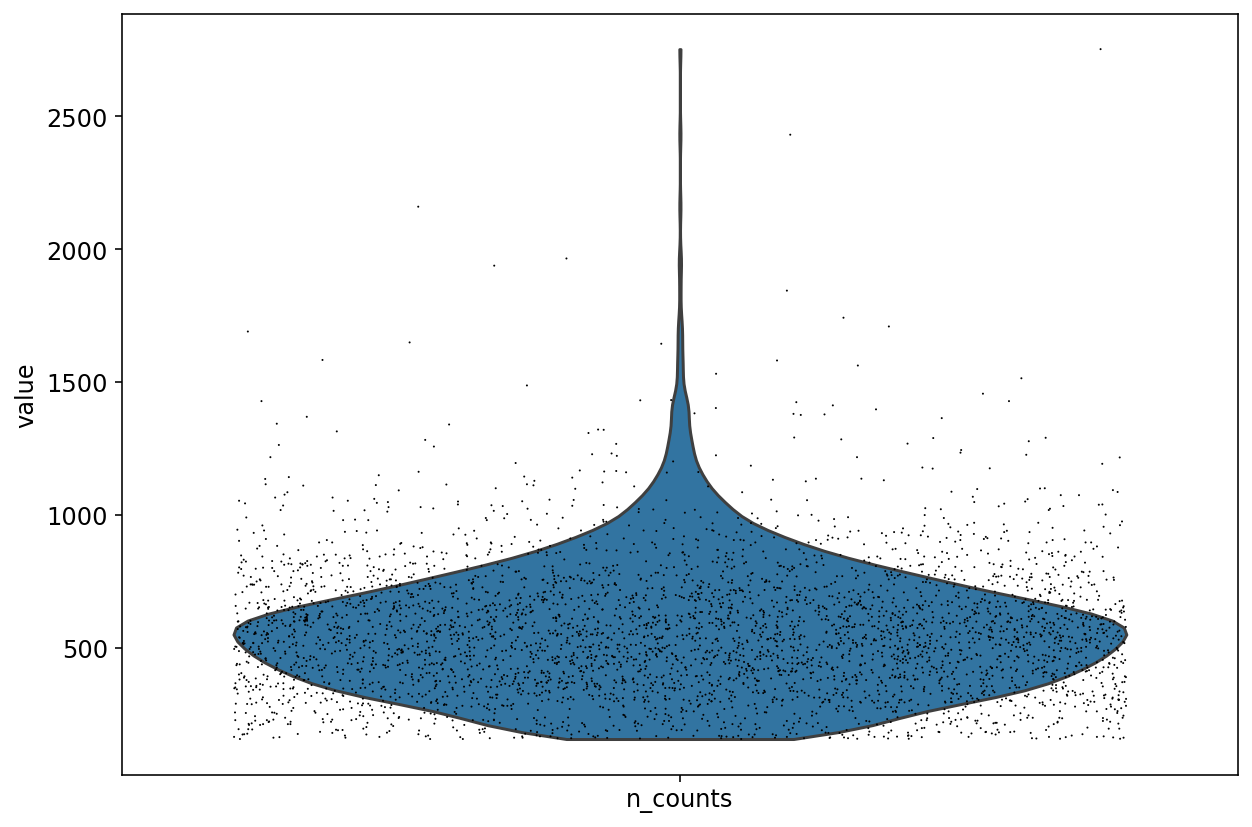

In [15]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.violin(adata, 'n_counts', jitter=0.4, ax=ax)

## Analysis

In this part of the tutorial, the cells are clustered by [Louvain community detection](https://en.wikipedia.org/wiki/Louvain_modularity).

### Normalizing the counts

In [0]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
# apply log(1 + count) to all counts
adata.raw = sc.pp.log1p(adata, copy=True)
sc.pp.log1p(adata)

### Viewing highly variable genes

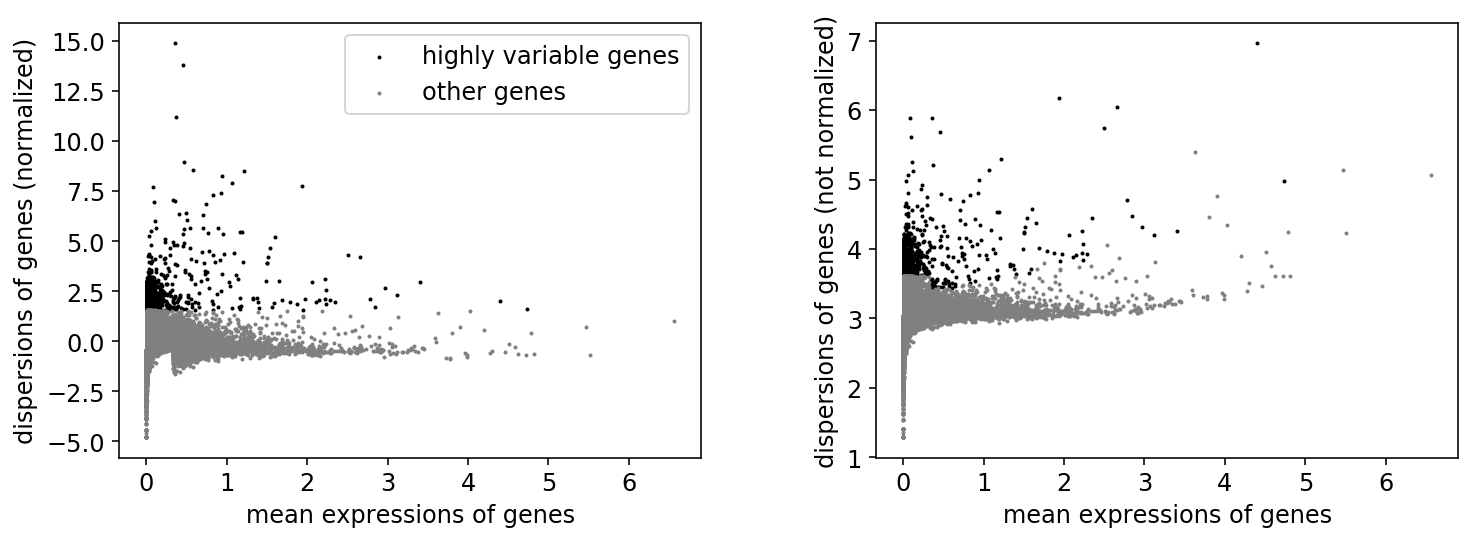

In [17]:
filter_result = sc.pp.highly_variable_genes(adata, min_disp=0.3, inplace=False, n_top_genes=1209)
sc.pl.highly_variable_genes(filter_result)

In [18]:
print("{:,} highly variable genes".format(sum(x[0] for x in filter_result)))

1,209 highly variable genes


### Clustering and visualization

In [19]:
%%time
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.louvain(adata)

CPU times: user 1min 17s, sys: 1.42 s, total: 1min 19s
Wall time: 42.7 s


### PCA

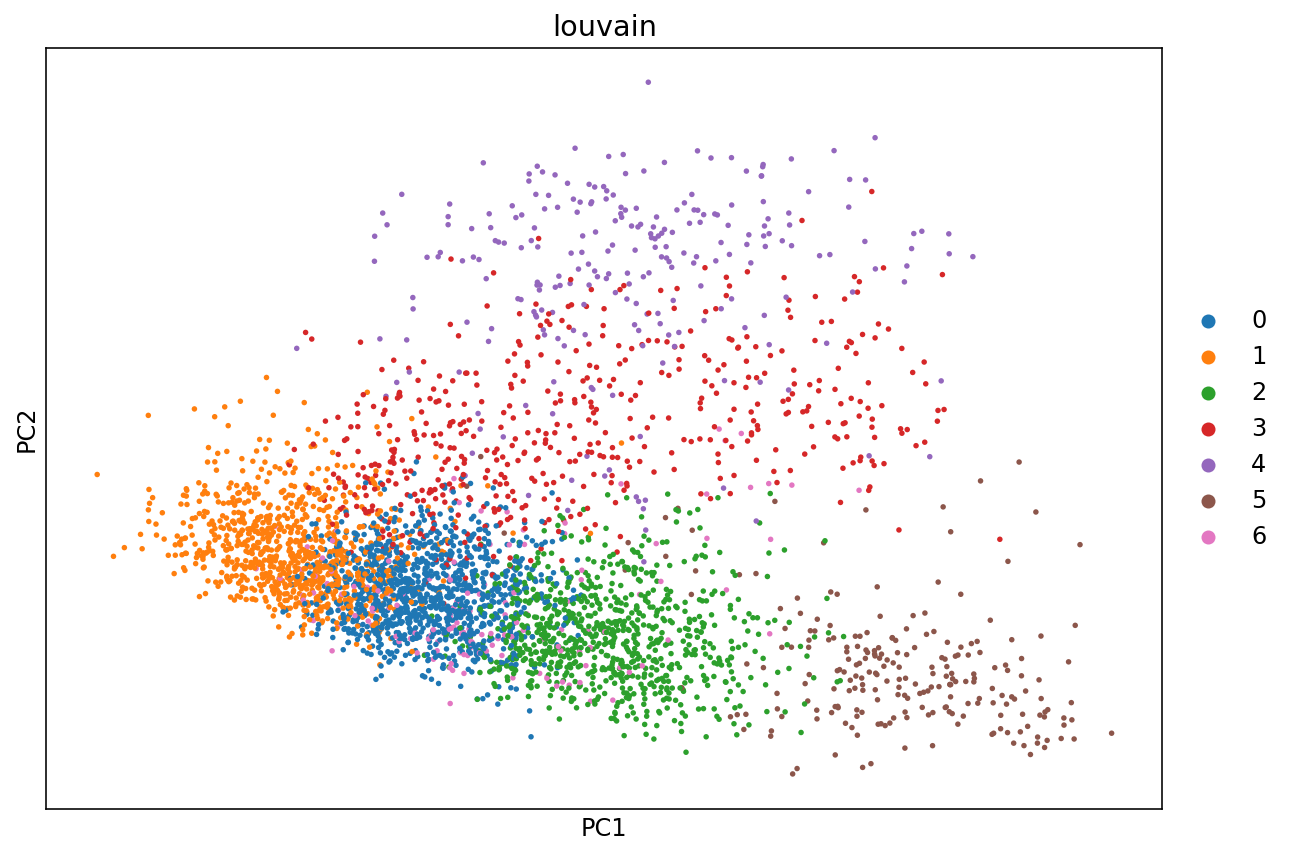

In [20]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.pca(adata, color='louvain', ax=ax)

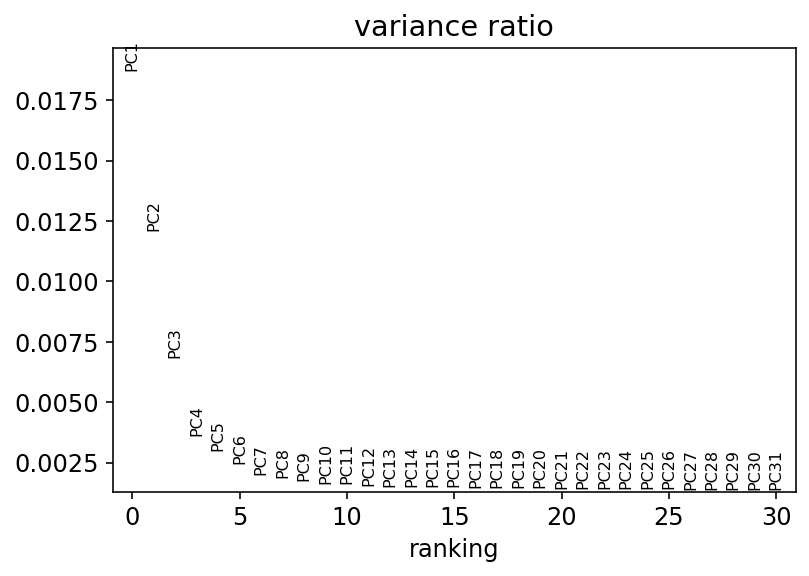

In [21]:
sc.pl.pca_variance_ratio(adata)

### UMAP

In [22]:
%%time
sc.tl.umap(adata)

CPU times: user 11.2 s, sys: 140 ms, total: 11.4 s
Wall time: 11.2 s


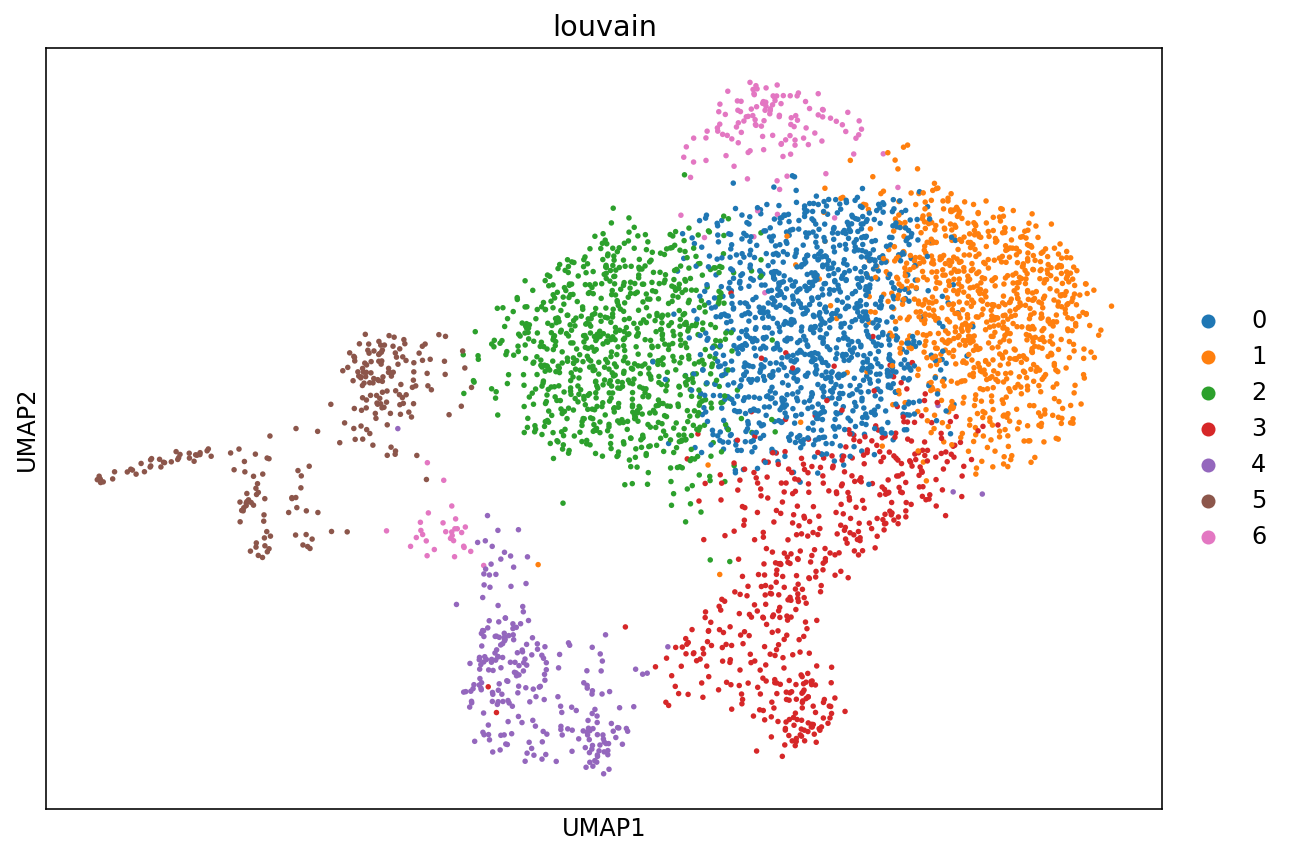

In [23]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.umap(adata, color='louvain', ax=ax)

### tSNE

In [24]:
%%time
sc.tl.tsne(adata, n_pcs=10)

CPU times: user 23.9 s, sys: 9.43 ms, total: 23.9 s
Wall time: 23.9 s


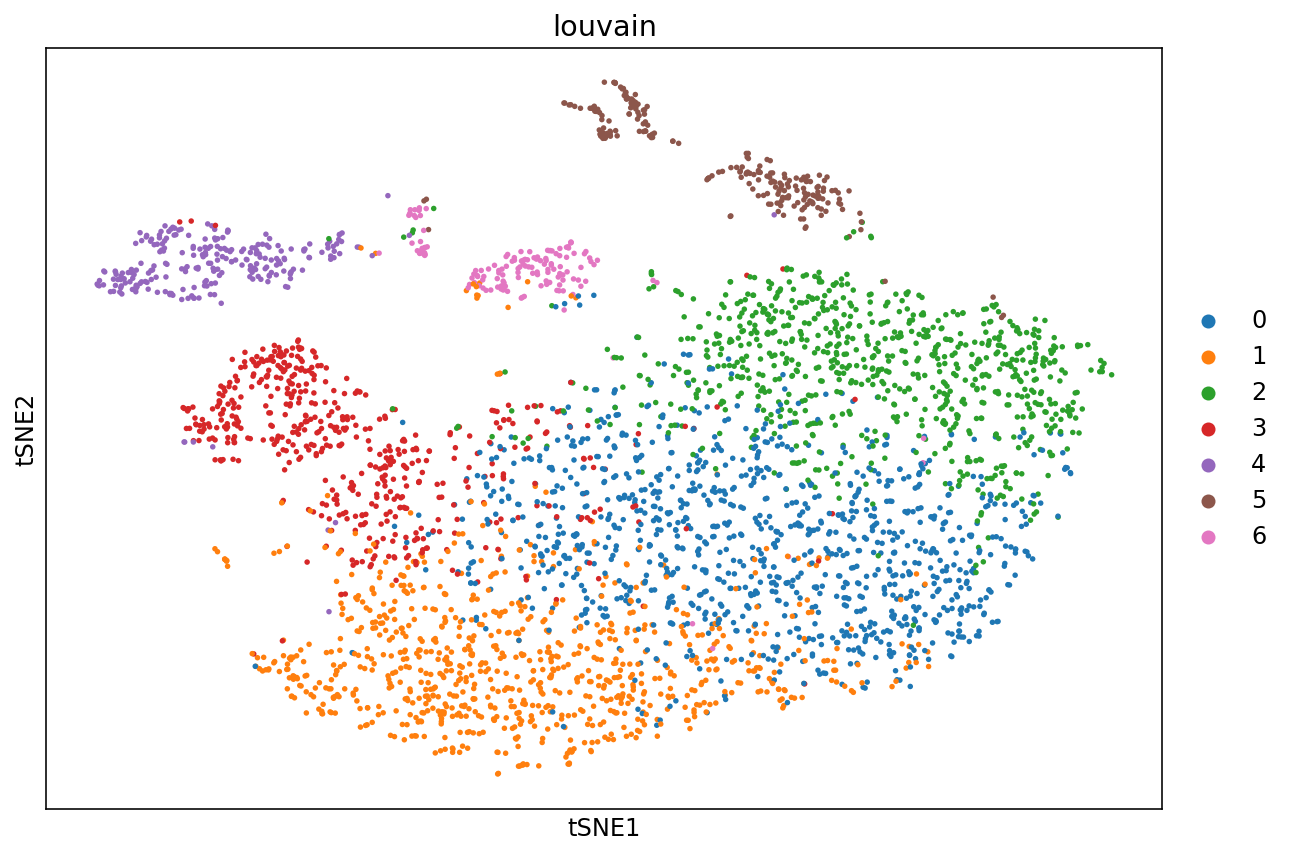

In [25]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.tsne(adata, color='louvain', ax=ax)

## Discussion

In [26]:
# Running time of the notebook
print("{:.2f} minutes".format((time.time()-start_time)/60))

12.81 minutes
